# NOAA 1158: Setup Heating Models
Simulation of loops in NOAA 1158 in which all of the strands are heated by nanoflares varying frequency. In this notebook, we will setup models for several different heating frequencies, likely low, intermediate, and high.

For all of the models created here, we will use the base AR model of NOAA 1158 that we've already built so that the geometry is consistent across all models.

In [51]:
import os
import logging
import warnings
import multiprocessing
import subprocess
import random
warnings.filterwarnings('ignore')

import numpy as np
from scipy.optimize import curve_fit
from sunpy.map import Map
import astropy.units as u
import astropy.constants as const
import matplotlib.pyplot as plt
import dask.distributed

import synthesizAR
from synthesizAR.model_ext import EbtelInterface
from synthesizAR.instruments import InstrumentSDOAIA

%matplotlib inline

## New Heating Model
This heating model uses the cooling time (as estimated using the loop length) to calculate the number of events and cooling intervals. This ensures that the prescribed heating frequency is occurring on each strand in the AR, independent of loop length (i.e. cooling time).

In [2]:
class CustomHeatingModel(object):
    def __init__(self,heating_options):
        self.heating_options = heating_options
        self.logger = logging.getLogger(name=type(self).__name__)
    
    def calculate_event_properties(self,loop):
        self.number_events = self._calculate_number_events(loop)
        rates = (self.power_law_distributions[loop.name]
                 /(self.heating_options['duration'] 
                   - 0.5*(self.heating_options['duration_rise'] + self.heating_options['duration_decay'])))
        delays = (self.base_config['total_time'] - self.number_events*self.heating_options['duration'])*rates/rates.sum()
        delays *= np.random.uniform(low=1. - 1./(self.number_events**2),high=1.)
        running_total = 0.0
        rise_start = np.empty(rates.shape)
        for i in range(self.number_events):
            running_total += delays[i]
            rise_start[i] = i*self.heating_options['duration'] + running_total
        rise_end = rise_start + self.heating_options['duration_rise']
        decay_start = rise_end
        decay_end = rise_start + self.heating_options['duration']
        return {'magnitude':rates,
                'rise_start':rise_start,
                'rise_end':rise_end,
                'decay_start':decay_start,
                'decay_end':decay_end
               }
    
    def _calculate_number_events(self,loop):
        mean_waiting_period = self.heating_options['frequency_parameter']*self.cooling_time(loop)
        num_events = int(np.floor((self.base_config['total_time'] + mean_waiting_period)/
                                  (self.heating_options['duration'] + mean_waiting_period))) 
        return num_events
    
    def power_law(self,a0,a1,alpha,x):
        return ((a1**(alpha + 1.) - a0**(alpha + 1.))*x + a0**(alpha + 1.))**(1./(alpha + 1.))
    
    def max_strand_energy(self,loop):
        return ((self.heating_options['stress_level']*loop.field_strength.value.max())**2)/8./np.pi
    
    def constrain_distribution(self,field,iterator_options):
        # Initialize quantities
        power_law_distributions = {}
        num_iterations = 0
        error = 1e300
        cross_sections = self.calculate_cross_sections(field)
        upper_bounds = np.array([self.max_strand_energy(loop) for loop in field.loops])
        lower_bounds = upper_bounds/100.
        
        # Iteratively adjust lower power-law bound
        while error > iterator_options['tolerance'] and num_iterations < iterator_options['max_iterations']:
            weights = np.empty(len(field.loops))
            # Calculate power-law distributions for all loops
            for i,loop in enumerate(field.loops):
                pl = self.power_law(lower_bounds[i],upper_bounds[i],self.heating_options['power_law_slope'],
                                    np.random.rand(self._calculate_number_events(loop)))
                power_law_distributions[loop.name] = pl
                weights[i] = pl.sum()*loop.full_length.value*cross_sections[i]
            
            # Update error terms
            phi = weights.sum()/cross_sections.sum()/iterator_options['total_ar_flux']/self.base_config['total_time']
            error = np.fabs(1. - 1./phi)
            # Update lower-bounds
            lower_bounds = np.minimum(np.maximum(lower_bounds + lower_bounds*(1. - phi),
                                                 iterator_options['delta0']*upper_bounds),
                                      iterator_options['delta1']*upper_bounds)
            num_iterations += 1
            
        if num_iterations == iterator_options['max_iterations']:
            warnings.warn('Max number of iterations reached with error {}'.format(error))
        
        self.power_law_distributions = power_law_distributions
    
    def cooling_time(self,loop):
        half_length = loop.full_length.value/2.
        average_heating_rate_max = self.max_strand_energy(loop)/(self.heating_options['duration']/2.)#*u.erg/(u.cm**3)/u.s
        # set some constants
        alpha = -0.5
        chi = 6e-20#*(u.erg*(u.cm**3)/u.s*u.K**(0.5))
        kappa_0 = 1e-6#*(u.erg/u.cm/u.s*(u.K**(-7/2)))
        c1,c2,c3 = 2.0,0.9,0.6
        gamma = 5./3.
        # estimate max n0T0
        T0 = c2*(7.*half_length**2*average_heating_rate_max/2./kappa_0)**(2./7.)
        top_term = average_heating_rate_max - 2.*kappa_0*(T0**(3.5))/(7.*(c2**2.5)*c3*(half_length**2)*gamma)
        bottom_term = c1*chi*(T0**alpha)*(1. - c2/c3/gamma)
        n0 = np.sqrt(top_term/bottom_term)
        n0T0 = n0*T0
        # Cargill cooling expression
        term1 = (2. - alpha)/(1. - alpha)
        term2 = (kappa_0**(4. - 2.*alpha))*(chi**7)
        term3 = ((half_length)**(8. - 4.*alpha))/(n0T0**(3+2.*alpha))
        return term1*3.*const.k_B.cgs.value*(1/term2*term3)**(1/(11. - 2.*alpha))
    
    def calculate_cross_sections(self,field):
        footpoints = np.array([loop.coordinates[0,:2].value for loop in field.loops])
        footpoint_dist,bin_edges = np.histogramdd(
            footpoints,
            bins = (field.clipped_hmi_map.dimensions.x.value,field.clipped_hmi_map.dimensions.y.value),
            range = (field._convert_angle_to_length(field.clipped_hmi_map.xrange).value,
                     field._convert_angle_to_length(field.clipped_hmi_map.yrange).value))
        area_per_pixel = (field._convert_angle_to_length(field.clipped_hmi_map.scale.x*1*u.pixel)
                          *field._convert_angle_to_length(field.clipped_hmi_map.scale.y*1*u.pixel)).value
        ix = np.digitize(footpoints[:,0],bin_edges[0]) - 1
        iy = np.digitize(footpoints[:,1],bin_edges[1]) - 1
        
        return (area_per_pixel/footpoint_dist)[ix,iy]

Setup the base heating options. These won't really change except for the frequency parameter.

In [3]:
base_heating_options = {
    'duration':200.0,
    'duration_rise':100.0,
    'duration_decay':100.0,
    'stress_level':0.3,
    'power_law_slope':-2.5
}

Set options for iterator that constrains the amount energy injected into the AR.

In [4]:
heating_model_iterator_options = {
    'tolerance':1e-2,
    'max_iterations':100,
    'delta0':1e-6,
    'delta1':1e-1,
    'total_ar_flux':1e7
}

Set base configuration for the EBTEL simulations as well.

In [5]:
ih = synthesizAR.util.InputHandler('/storage-home/w/wtb2/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml')
base_config = ih.lookup_vars()
base_config['c1_cond0'] = 6.0
base_config['total_time'] = 3e4
base_config['use_adaptive_solver'] = True
base_config['use_flux_limiting'] = True
base_config['calculate_dem'] = False
base_config['heating']['partition'] = 1.0
base_config['heating']['background'] = 1e-6
base_config['force_single_fluid'] = False
base_config['tau_max'] = 200.0

Setup a runner for doing the EBTEL simulations in parallel.

In [ ]:
def ebtel_runner(loop):
    subprocess.call([os.path.join('/storage-home/w/wtb2/codes/','ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

## High-frequency Heating

First off, load the base field model. We will build all other models off of this one.

In [ ]:
high_frequency_field = synthesizAR.Skeleton.restore('../../../data/base_noaa1158')

Configure the heating model.

In [6]:
high_frequency_heating_options = base_heating_options.copy()
high_frequency_heating_options['frequency_parameter'] = 0.1
high_frequency_heating_model = CustomHeatingModel(high_frequency_heating_options)
ebtel_interface = EbtelInterface(base_config,high_frequency_heating_model,
                                 '/storage-home/w/wtb2/data/noaa1158_high_frequency/hydro_config/',
                                 '/storage-home/w/wtb2/data/noaa1158_high_frequency/hydro_results/'
                                )

Run the flux constraint iterator to calculate the power-law distributions for the heating rates on each loop.

In [ ]:
high_frequency_heating_model.constrain_distribution(high_frequency_field,heating_model_iterator_options)

Configure the simulations

In [ ]:
high_frequency_field.configure_loop_simulations(ebtel_interface)

Run all of the EBTEL simulations

In [ ]:
pool = multiprocessing.Pool()

In [ ]:
runs = pool.map_async(ebtel_runner,high_frequency_field.loops)
runs.wait()

In [ ]:
pool.close()

And load everything back into the field.

In [ ]:
high_frequency_field.load_loop_simulations(ebtel_interface,
                                           savefile='/storage-home/w/wtb2/data/noaa1158_high_frequency/loop_parameters.h5')

Take a look at the hydrodynamic results

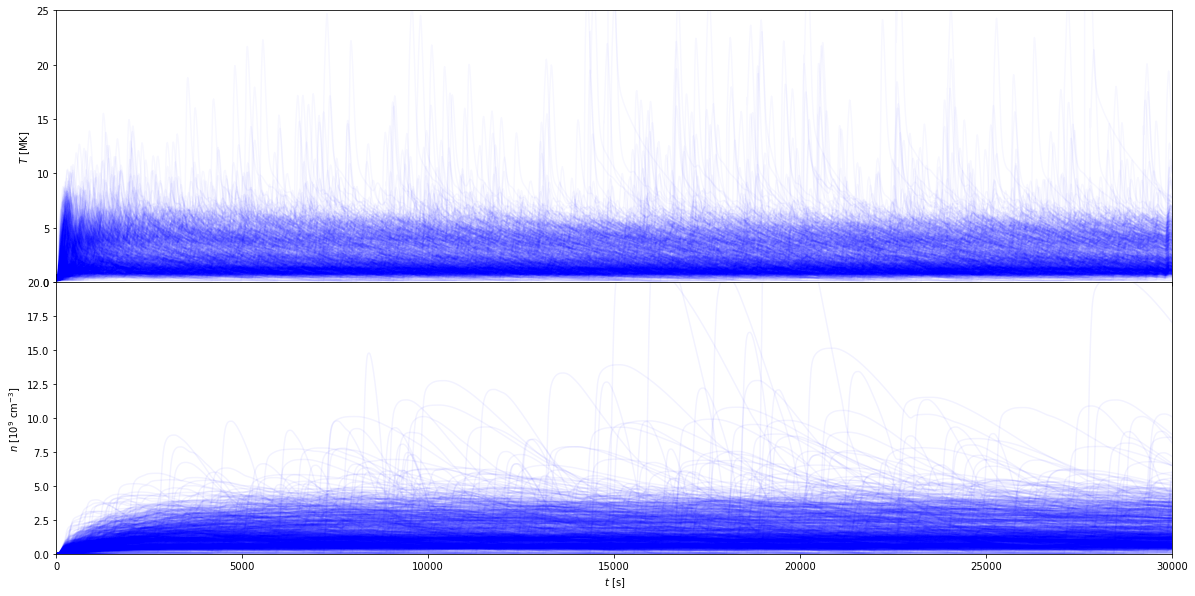

In [68]:
fig,axes = plt.subplots(2,1,figsize=(20,10),sharex=True)
plt.subplots_adjust(hspace=0.)
for loop in high_frequency_field.loops[::10]:
    axes[0].plot(loop.time,loop.electron_temperature[:,0].to(u.MK),color='b',alpha=0.03)
    #axes[0].plot(loop.time,loop.ion_temperature[:,0].to(u.MK),color='r',alpha=0.03)
    axes[1].plot(loop.time,loop.density[:,0]/1e9,color='b',alpha=0.05)
axes[0].set_xlim([0,base_config['total_time']])
axes[0].set_ylim([0,25])
axes[1].set_ylim([0,20])
axes[0].set_ylabel(r'$T$ [MK]')
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]')
axes[1].set_xlabel(r'$t$ [s]')

Finally, save the field so that we can reload it later if we want.

In [ ]:
high_frequency_field.save('/storage-home/w/wtb2/data/noaa1158_high_frequency/field_checkpoint')

Restore the field here if necessary.

In [7]:
high_frequency_field = synthesizAR.Skeleton.restore('/storage-home/w/wtb2/data/noaa1158_high_frequency/field_checkpoint/')

No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-10-03 16:02:04,567 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-10-03 16:02:04,568 Parameters: domain_dimensions         = [95 96 96]
yt : [INFO     ] 2017-10-03 16:02:04,568 Parameters: domain_left_edge          = [ -2.96081016e+10  -2.62091384e+10   3.91869796e+08]
yt : [INFO     ] 2017-10-03 16:02:04,569 Parameters: domain_right_edge         = [ -1.18463315e+10  -7.41270210e+09   1.92016200e+10]
yt : [INFO     ] 2017-10-03 16:02:04,570 Parameters: cosmological_simulation   = 0.0


In [31]:
loop_lengths = []
waiting_times = []
heating_rates = []
for loop in high_frequency_field.loops:
    delays = np.diff(np.array([0.]+[e['event']['decay_end'] for e in loop.hydro_configuration['heating']['events']]))
    delays -= 200.0
    rates = np.array([e['event']['magnitude'] for e in loop.hydro_configuration['heating']['events']])
    waiting_times += delays.tolist()
    max_rate = high_frequency_heating_model.max_strand_energy(loop)
    heating_rates += (rates/max_rate).tolist()
    loop_lengths += len(delays)*[loop.full_length.value]
cooling_times = [high_frequency_heating_model.cooling_time(loop) for loop in high_frequency_field.loops]

In [35]:
heating_rates_high = heating_rates.copy()

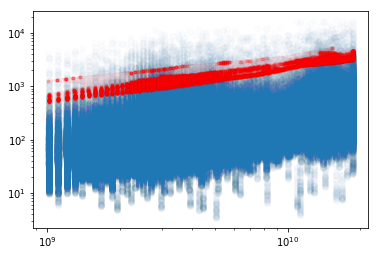

In [26]:
plt.scatter(loop_lengths,waiting_times,alpha=0.01)
plt.plot([loop.full_length.value for loop in high_frequency_field.loops],cooling_times,'r.',ls=None,alpha=0.1)
plt.xscale('log')
plt.yscale('log')

In [27]:
max_heating_rates = np.array([high_frequency_heating_model.max_strand_energy(loop) for loop in high_frequency_field.loops])/100.

(1000000000.0, 20000000000.0)

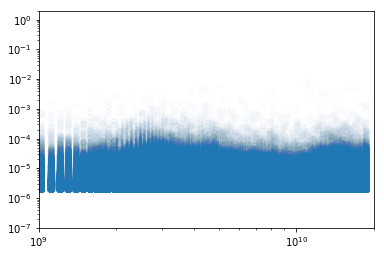

In [34]:
plt.scatter(loop_lengths,heating_rates,alpha=0.01)
#plt.plot([loop.full_length.value for loop in high_frequency_field.loops],max_heating_rates,'r.',alpha=0.1)
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-7,2])
plt.xlim([1e9,2e10])

## Intermediate-frequency Heating

In [ ]:
intermediate_frequency_field = synthesizAR.Skeleton.restore('../../../data/base_noaa1158')

In [ ]:
intermediate_frequency_heating_options = base_heating_options.copy()
intermediate_frequency_heating_options['frequency_parameter'] = 1.0
intermediate_frequency_heating_model = CustomHeatingModel(intermediate_frequency_heating_options)
ebtel_interface = EbtelInterface(base_config,intermediate_frequency_heating_model,
                                 '/storage-home/w/wtb2/data/noaa1158_intermediate_frequency/hydro_config/',
                                 '/storage-home/w/wtb2/data/noaa1158_intermediate_frequency/hydro_results/'
                                )

In [ ]:
intermediate_frequency_heating_model.constrain_distribution(intermediate_frequency_field,heating_model_iterator_options)

In [ ]:
intermediate_frequency_field.configure_loop_simulations(ebtel_interface)

In [ ]:
pool = multiprocessing.Pool()

In [ ]:
runs = pool.map_async(ebtel_runner,intermediate_frequency_field.loops)
runs.wait()

In [ ]:
pool.terminate()

In [ ]:
intermediate_frequency_field.load_loop_simulations(ebtel_interface,
                                                   savefile='/storage-home/w/wtb2/data/noaa1158_intermediate_frequency/loop_parameters.h5')

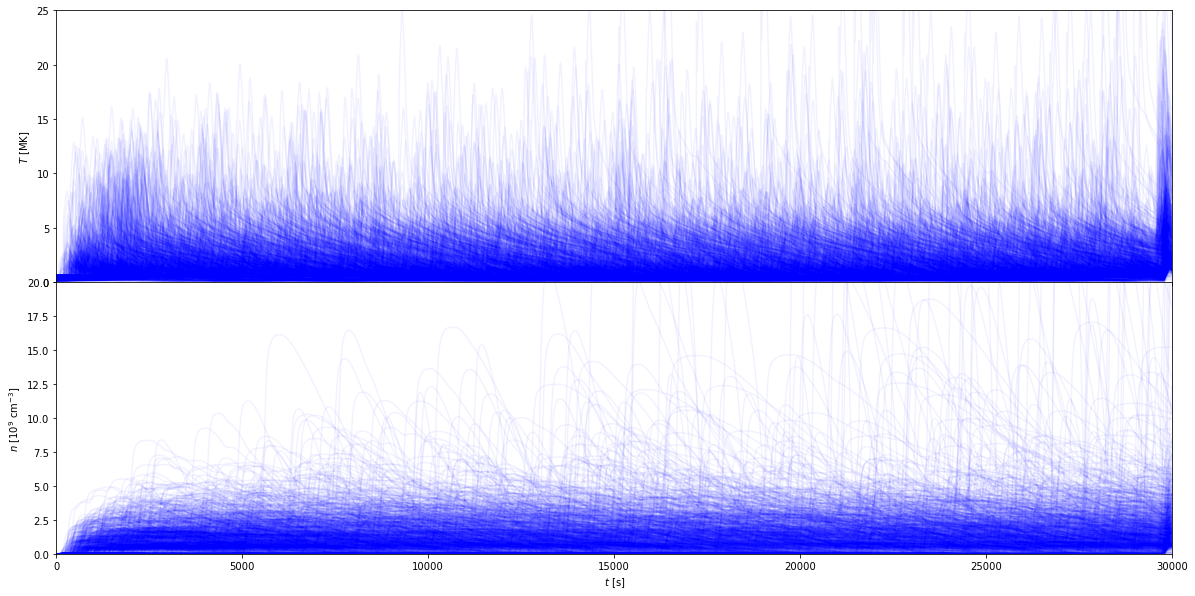

In [70]:
fig,axes = plt.subplots(2,1,figsize=(20,10),sharex=True)
plt.subplots_adjust(hspace=0.)
for loop in intermediate_frequency_field.loops[::10]:
    axes[0].plot(loop.time,loop.electron_temperature[:,0].to(u.MK),color='b',alpha=0.05)
    #axes[0].plot(loop.time,loop.ion_temperature[:,0].to(u.MK),color='r',alpha=0.05)
    axes[1].plot(loop.time,loop.density[:,0]/1e9,color='b',alpha=0.05)
axes[0].set_ylim([0,25])
axes[1].set_ylim([0,20])
axes[0].set_xlim([0,base_config['total_time']])
axes[0].set_ylabel(r'$T$ [MK]')
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]')
axes[1].set_xlabel(r'$t$ [s]')

In [ ]:
intermediate_frequency_field.save('/storage-home/w/wtb2/data/noaa1158_intermediate_frequency/field_checkpoint')

In [10]:
intermediate_frequency_field = synthesizAR.Skeleton.restore('/storage-home/w/wtb2/data/noaa1158_intermediate_frequency/field_checkpoint')

No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-10-03 16:03:05,798 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-10-03 16:03:05,799 Parameters: domain_dimensions         = [95 96 96]
yt : [INFO     ] 2017-10-03 16:03:05,800 Parameters: domain_left_edge          = [ -2.96081016e+10  -2.62091384e+10   3.91869796e+08]
yt : [INFO     ] 2017-10-03 16:03:05,800 Parameters: domain_right_edge         = [ -1.18463315e+10  -7.41270210e+09   1.92016200e+10]
yt : [INFO     ] 2017-10-03 16:03:05,801 Parameters: cosmological_simulation   = 0.0


In [36]:
loop_lengths = []
waiting_times = []
heating_rates = []
for loop in intermediate_frequency_field.loops:
    delays = np.diff(np.array([0.]+[e['event']['decay_end'] for e in loop.hydro_configuration['heating']['events']]))
    delays -= 200.0
    rates = np.array([e['event']['magnitude'] for e in loop.hydro_configuration['heating']['events']])
    waiting_times += delays.tolist()
    max_rate = high_frequency_heating_model.max_strand_energy(loop)
    heating_rates += (rates/max_rate).tolist()
    loop_lengths += len(delays)*[loop.full_length.value]
cooling_times = [high_frequency_heating_model.cooling_time(loop) for loop in intermediate_frequency_field.loops]

In [37]:
heating_rates_intermediate = heating_rates.copy()

In [ ]:
plt.scatter(loop_lengths,waiting_times,alpha=0.01)
plt.plot([loop.full_length.value for loop in intermediate_frequency_field.loops],cooling_times,'r.',ls=None,alpha=0.1)
plt.xscale('log')
plt.yscale('log')

(1000000000.0, 20000000000.0)

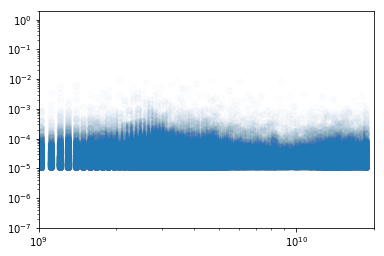

In [39]:
plt.scatter(loop_lengths,heating_rates,alpha=0.01)
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-7,2])
plt.xlim([1e9,2e10])

## Low-frequency Heating

In [ ]:
low_frequency_field = synthesizAR.Skeleton.restore('../../../data/base_noaa1158')

In [ ]:
low_frequency_heating_options = base_heating_options.copy()
low_frequency_heating_options['frequency_parameter'] = 5.0
low_frequency_heating_model = CustomHeatingModel(low_frequency_heating_options)
ebtel_interface = EbtelInterface(base_config,low_frequency_heating_model,
                                 '/storage-home/w/wtb2/data/noaa1158_low_frequency/hydro_config/',
                                 '/storage-home/w/wtb2/data/noaa1158_low_frequency/hydro_results/'
                                )

In [ ]:
low_frequency_heating_model.constrain_distribution(low_frequency_field,heating_model_iterator_options)

In [ ]:
low_frequency_field.configure_loop_simulations(ebtel_interface)

In [ ]:
pool = multiprocessing.Pool()

In [ ]:
runs = pool.map_async(ebtel_runner,low_frequency_field.loops)
runs.wait()

In [ ]:
pool.terminate()

In [ ]:
low_frequency_field.load_loop_simulations(ebtel_interface,
                                          savefile='/storage-home/w/wtb2/data/noaa1158_low_frequency/loop_parameters.h5')

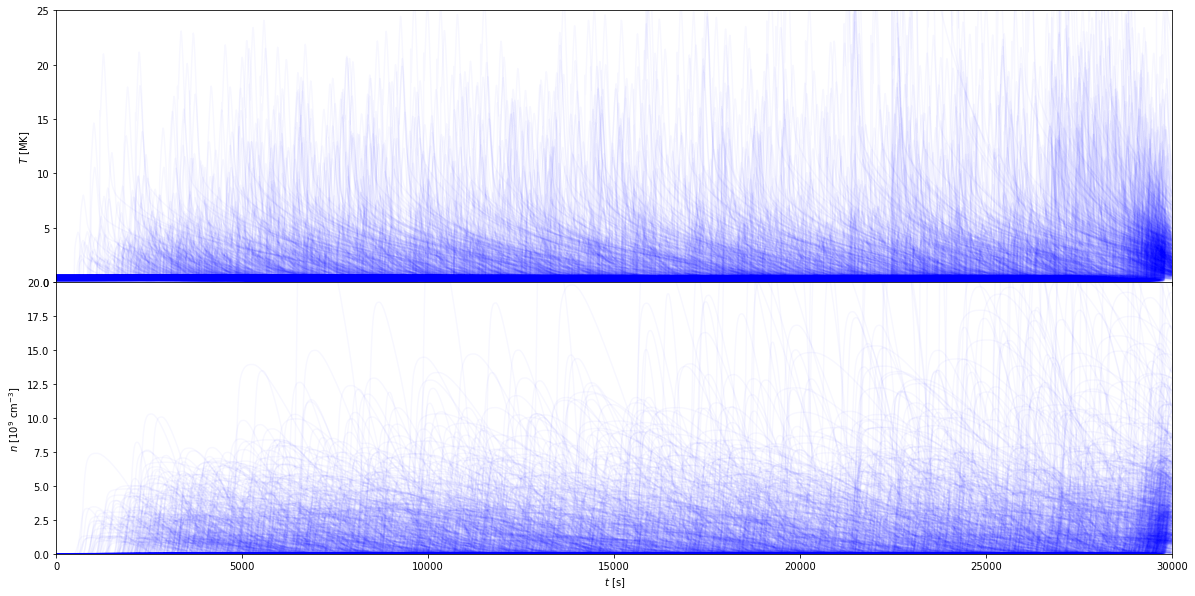

In [69]:
fig,axes = plt.subplots(2,1,figsize=(20,10),sharex=True)
plt.subplots_adjust(hspace=0.)
for loop in low_frequency_field.loops[::10]:
    axes[0].plot(loop.time,loop.electron_temperature[:,0].to(u.MK),color='b',alpha=0.03)
    #axes[0].plot(loop.time,loop.ion_temperature[:,0].to(u.MK),color='r',alpha=0.05)
    axes[1].plot(loop.time,loop.density[:,0]/1e9,color='b',alpha=0.03)
axes[0].set_ylim([0,25])
axes[1].set_ylim([0,20])
axes[0].set_xlim([0,base_config['total_time']])
axes[0].set_ylabel(r'$T$ [MK]')
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]')
axes[1].set_xlabel(r'$t$ [s]')

In [ ]:
low_frequency_field.save('/storage-home/w/wtb2/data/noaa1158_low_frequency/field_checkpoint')

In [13]:
low_frequency_field = synthesizAR.Skeleton.restore('/storage-home/w/wtb2/data/noaa1158_low_frequency/field_checkpoint')

No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-10-03 16:03:26,454 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-10-03 16:03:26,455 Parameters: domain_dimensions         = [95 96 96]
yt : [INFO     ] 2017-10-03 16:03:26,456 Parameters: domain_left_edge          = [ -2.96081016e+10  -2.62091384e+10   3.91869796e+08]
yt : [INFO     ] 2017-10-03 16:03:26,457 Parameters: domain_right_edge         = [ -1.18463315e+10  -7.41270210e+09   1.92016200e+10]
yt : [INFO     ] 2017-10-03 16:03:26,458 Parameters: cosmological_simulation   = 0.0


In [40]:
loop_lengths = []
waiting_times = []
heating_rates = []
for loop in low_frequency_field.loops:
    delays = np.diff(np.array([0.]+[e['event']['decay_end'] for e in loop.hydro_configuration['heating']['events']]))
    delays -= 200.0
    rates = np.array([e['event']['magnitude'] for e in loop.hydro_configuration['heating']['events']])
    waiting_times += delays.tolist()
    max_rate = high_frequency_heating_model.max_strand_energy(loop)
    heating_rates += (rates/max_rate).tolist()
    loop_lengths += len(delays)*[loop.full_length.value]
cooling_times = [high_frequency_heating_model.cooling_time(loop) for loop in low_frequency_field.loops]

In [41]:
heating_rates_low = heating_rates.copy()

In [ ]:
plt.scatter(loop_lengths,waiting_times,alpha=0.01)
plt.plot([loop.full_length.value for loop in low_frequency_field.loops],cooling_times,'r.',ls=None,alpha=0.1)
plt.xscale('log')
plt.yscale('log')

In [ ]:
plt.scatter(loop_lengths,heating_rates,alpha=0.01)
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-5,2e1])
plt.xlim([1e9,2e10])

high-frequency, a = -2.5617823985231407
intermediate-frequency, a = -2.576813169679661
low-frequency, a = -2.570516419877337


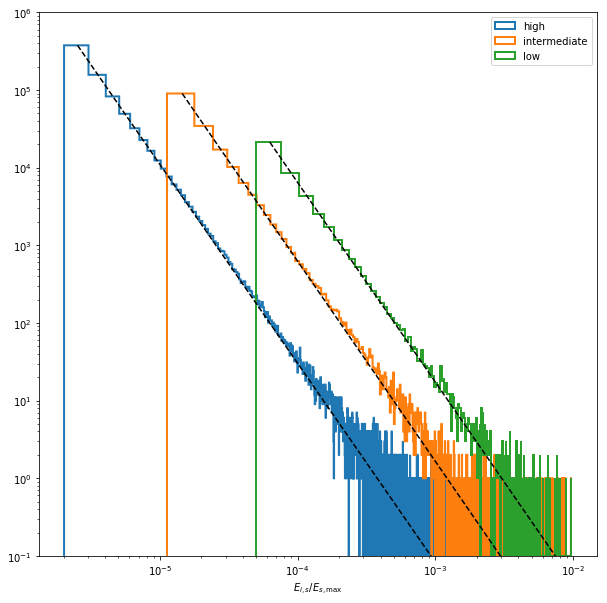

In [66]:
plt.figure(figsize=(10,10))
params = {'histtype':'step',
          'lw':2,
          'bins':'scott',#np.logspace(-6,0,100),
          'log':True,
          'normed':False}
foo = plt.hist(heating_rates_high,label='high',**params)
h = foo[0]
x = foo[1]
x = (x[1:] + x[:-1])/2.
def linear_fit(x,a,b):
    return b*x**a
popt,pcov = curve_fit(linear_fit,x,h)
plt.plot(x,linear_fit(x,*popt),'--k')
print('high-frequency, a = {}'.format(popt[0]))
foo = plt.hist(heating_rates_intermediate,label='intermediate',**params)
h = foo[0]
x = foo[1]
x = (x[1:] + x[:-1])/2.
def linear_fit(x,a,b):
    return b*x**a
popt,pcov = curve_fit(linear_fit,x,h)
plt.plot(x,linear_fit(x,*popt),'--k')
print('intermediate-frequency, a = {}'.format(popt[0]))
foo = plt.hist(heating_rates_low,label='low',**params)
h = foo[0]
x = foo[1]
x = (x[1:] + x[:-1])/2.
def linear_fit(x,a,b):
    return b*x**a
popt,pcov = curve_fit(linear_fit,x,h)
plt.plot(x,linear_fit(x,*popt),'--k')
print('low-frequency, a = {}'.format(popt[0]))
plt.xscale('log')
plt.xlabel(r'$E_{i,s}/E_{s,\max}$')
plt.ylim([0.1,1e6])
plt.legend()